## Import Req'd Libraries 

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Getting all the file_names in a given directory
def get_file_names(folder):
    #Listing entries present in given folder
    entries = os.listdir(folder)
    for i in entries:
        if 'csv' not in i:
            entries.remove(i)
    return sorted(entries, reverse=True)

#Saving the file
def save_file(root, name_of_file, my_dataframe):
    #Test if save directory exists
    try:
        my_dataframe.to_csv(root+'processed_data/'+ name_of_file, index=False)
    #Otherwise make the directory and then save
    except:
        os.mkdir(root+'processed_data')
        my_dataframe.to_csv(root+'processed_data/'+ name_of_file, index=False)

In [3]:
def initialization(filepath):
    df = pd.read_csv(filepath, 
                     usecols = ['id','last_scraped', 'host_is_superhost', 
                            'latitude','longitude', 'property_type',
                           'room_type','accommodates','bathrooms',
                           'bedrooms','beds','amenities', 'price',
                            'instant_bookable ','cancellation_policy'])
    df["last_scraped"] = pd.to_datetime(df["last_scraped"])
    df["price"] = df["price"].apply(lambda x: x.replace('$','').replace(',', '').replace('.00', '')).astype("int")
    return df

## Concatenating All Data Together

In [4]:
# get list of filenames
root = '../'
name = get_file_names(root+'original_dataset')
accum_kept = 0
accum_removed = 0

# combine all files into one
print("COMBINING INTO ONE DATAFRAME...")
frames = []
for i in name:
    print("--Processing: ", i)
    filepath = root+'original_dataset/'+i
    frames.append(initialization(filepath))
full_df = pd.concat(frames, sort=False)

initial_samples = len(full_df)
print("Initial # of Samples: ", len(full_df))

print(" ")

# Drop missing values
print("DELETING SAMPLES WITH MISSING VALUES...")
full_df = full_df.dropna()
samples1 = len(full_df)
print("--Number of Samples Removed: ", initial_samples-samples1)

# reset index
full_df = full_df.reset_index(drop=True)

COMBINING INTO ONE DATAFRAME...
--Processing:  19_08_08_listings.csv
--Processing:  19_07_08_listings.csv
--Processing:  19_06_04_listings.csv
--Processing:  19_05_06_listings.csv
--Processing:  19_04_08_listings.csv
--Processing:  19_03_07_listings.csv
--Processing:  19_02_04_listings.csv
--Processing:  19_01_13_listings.csv
--Processing:  18_12_06_listings.csv
--Processing:  18_11_04_listings.csv
--Processing:  18_10_06_listings.csv
--Processing:  18_09_08_listings.csv
--Processing:  18_08_08_listings.csv
--Processing:  18_07_06_listings.csv
--Processing:  18_05_11_listings.csv
--Processing:  18_04_09_listings.csv
--Processing:  17_06_03_listings.csv
--Processing:  17_04_03_listings.csv
--Processing:  17_03_03_listings.csv
Initial # of Samples:  339763
 
DELETING SAMPLES WITH MISSING VALUES...
--Number of Samples Removed:  896


## Numericalize Categorical Data

#### Mapping for Categorical Features

In [5]:
cancellation_policies = {
    "flexible": 1,
    "moderate": 5,
    "strict_14_with_grace_period": 14,
    "strict": 14,
    "super_strict_30": 30,
    "super_strict_60": 60
}
room_types = {
    "Entire home/apt": 0,
    "Private room": 1,
    "Shared room": 2
}
true_false = {
    't': 1,
    'f': 0,
    True: 1,
    False: 0
}

In [6]:
# convert t/f into 1/0
print("NUMERICALIZING TRUE/FALSE...")
for i in ["host_is_superhost", "instant_bookable"]:
    full_df[i] = full_df[i].map(true_false)
    print(full_df[i].value_counts())

print(" ")

# cancellation policy
print("NUMERICALIZING CANCELLATION POLICY...")
print(full_df["cancellation_policy"].value_counts())
full_df["cancellation_policy"] = full_df["cancellation_policy"].map(cancellation_policies)

print(" ")

# room_type
print("NUMERICALIZING ROOM TYPE...")
print(full_df["room_type"].value_counts())
full_df["room_type"] = full_df["room_type"].map(room_types)


NUMERICALIZING TRUE/FALSE...
0    258051
1     80816
Name: host_is_superhost, dtype: int64
0    221082
1    117785
Name: instant_bookable, dtype: int64
 
NUMERICALIZING CANCELLATION POLICY...
strict_14_with_grace_period    114141
flexible                       103214
moderate                       100729
strict                          20189
super_strict_30                   418
super_strict_60                   176
Name: cancellation_policy, dtype: int64
 
NUMERICALIZING ROOM TYPE...
Entire home/apt    216813
Private room       115802
Shared room          6252
Name: room_type, dtype: int64


#### Mapping for Property Types

In [7]:
property_types = {
    "House" : 1,
    "Apartment" : 2,
    "Condominium" : 5,
    "Townhouse" : 3,
    "Bungalow" : 0,
    "Loft" : 4,
    "Serviced apartment" : 6,
    "Guest suite" : 7
}

In [8]:
print("FILTERLING AND NUMERICALIZING PROPERTY TYPES...")
property_type_counts = full_df["property_type"].value_counts()
accum = []
for i in range(len(property_type_counts)):
    if property_type_counts[i] >= 0.01*samples1:
        accum.append(property_type_counts.index[i])
print("Types of Included Properties:")
print(accum)

full_df = full_df[full_df["property_type"].isin(accum)]
print(full_df["property_type"].value_counts())

full_df["property_type"] = full_df["property_type"].map(property_types)

samples2 = len(full_df)
print("Number of Samples Removed:", samples1 - samples2)
full_df = full_df.reset_index(drop=True)

FILTERLING AND NUMERICALIZING PROPERTY TYPES...
Types of Included Properties:
['Apartment', 'House', 'Condominium', 'Townhouse', 'Guest suite', 'Bungalow', 'Loft', 'Serviced apartment']
Apartment             115562
House                  92156
Condominium            77328
Townhouse              15346
Guest suite            10323
Bungalow                8995
Loft                    7769
Serviced apartment      3441
Name: property_type, dtype: int64
Number of Samples Removed: 7947


## Store Mean and Std Dev

In [9]:
mean_std = pd.DataFrame(columns = ["mean", "std"])

## Normalizing Price

In [10]:
print("(BEFORE) PRICE STATISTICS...")
print(full_df["price"].describe())
print(full_df["price"].quantile([0.01, 0.05, 0.1, 0.9, 0.95, 0.99]))

print("")
print("TRIMMING PRICE OUTLIERS...")
min_price = full_df["price"].quantile(0.05)
max_price = full_df["price"].quantile(0.95)

full_df = full_df[(full_df["price"] >= min_price) & (full_df["price"] <= max_price)]
samples3 = len(full_df)
print("--Number of Samples Removed: ", samples2-samples3)
full_df = full_df.reset_index(drop=True)

print("")
print("STANDARDIZING PRICE...") # using Z-score
mean_price = full_df["price"].mean()
std_price = full_df["price"].std()
full_df["price"] = (full_df["price"] - mean_price)/std_price
print("--Mean Price: ", mean_price)
print("--Std Price: ", std_price)
temp = pd.DataFrame([[mean_price, std_price]], columns=["mean", "std"], index=["price"])
mean_std = mean_std.append(temp)

(BEFORE) PRICE STATISTICS...
count    330920.000000
mean        138.338674
std         223.728438
min           0.000000
25%          65.000000
50%         100.000000
75%         158.000000
max       13426.000000
Name: price, dtype: float64
0.01     25.0
0.05     35.0
0.10     42.0
0.90    250.0
0.95    340.0
0.99    695.0
Name: price, dtype: float64

TRIMMING PRICE OUTLIERS...
--Number of Samples Removed:  31190

STANDARDIZING PRICE...
--Mean Price:  116.66989623994928
--Std Price:  64.50950697384589


## Categorizing Amenities

In [11]:
amenities = ['Kitchen', 'Heating', 'Washer', 'Wifi', 'Indoor fireplace', 'Iron', 
             'Laptop friendly workspace', 'Crib', 'Self check-in', 'Carbon monoxide detector', 
             'Shampoo', 'Air conditioning', 'Dryer', 'Breakfast', 'Hangers', 'Hair dryer', 
             'TV', 'High chair', 'Smoke detector', 'Private bathroom']

facilities = ['Free parking on premises', 'Gym', 'Hot tub', 'Pool']

house_rules = ['Suitable for events', 'Pets allowed', 'Smoking allowed']

In [12]:
for i in amenities:
    full_df["amenities_"+i] = full_df["amenities"].apply(lambda x: 1 if i in x else 0)
full_df["amenities_count"] = sum(full_df["amenities_"+i] for i in amenities)

for i in facilities:
    full_df["facilities_"+i] = full_df["amenities"].apply(lambda x: 1 if i in x else 0)
full_df["facilities_count"] = sum(full_df["facilities_"+i] for i in facilities)

for i in house_rules:
    full_df["house_rules_"+i] = full_df["amenities"].apply(lambda x: 1 if i in x else 0)
full_df["house_rules_count"] = sum(full_df["house_rules_"+i] for i in house_rules)

## Standardizing Numerical Features


In [13]:
for i in ["latitude", "longitude", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "cancellation_policy", "amenities_count", "facilities_count", "house_rules_count"]:
    print("STANDARDIZING "+i.upper()+"...")
    mean = full_df[i].mean()
    std = full_df[i].std()
    temp = pd.DataFrame([[mean, std]], columns=["mean", "std"], index=[i])
    mean_std = mean_std.append(temp)
    full_df[i] = (full_df[i] - mean)/std
    print("--Mean: ", mean)
    print("--Std: ", std)
    print("")

STANDARDIZING LATITUDE...
--Mean:  43.676809784148745
--Std:  0.04554592892958044

STANDARDIZING LONGITUDE...
--Mean:  -79.39828395164194
--Std:  0.05900719717101783

STANDARDIZING PROPERTY_TYPE...
--Mean:  2.7108364194441665
--Std:  1.7767464682222966

STANDARDIZING ROOM_TYPE...
--Mean:  0.34876388749874887
--Std:  0.5003425822781011

STANDARDIZING ACCOMMODATES...
--Mean:  3.005988723184199
--Std:  1.7176376955146249

STANDARDIZING BATHROOMS...
--Mean:  1.192201314516398
--Std:  0.44686850025953645

STANDARDIZING BEDROOMS...
--Mean:  1.2542655056217262
--Std:  0.746440811838885

STANDARDIZING BEDS...
--Mean:  1.6029126213592233
--Std:  0.936888343006169

STANDARDIZING CANCELLATION_POLICY...
--Mean:  7.356767757648551
--Std:  5.680221001387256

STANDARDIZING AMENITIES_COUNT...
--Mean:  11.86548226737397
--Std:  2.9138074998369667

STANDARDIZING FACILITIES_COUNT...
--Mean:  1.0710806392419845
--Std:  1.1857763571463689

STANDARDIZING HOUSE_RULES_COUNT...
--Mean:  0.18897340940179494
--S

## Numericalize Date

In [15]:
print("STANDARDIZING DATE...")
full_df["last_scraped"] = full_df["last_scraped"].apply(lambda x: x.timestamp())
mean = full_df["last_scraped"].mean()
std = full_df["last_scraped"].std()
temp = pd.DataFrame([[mean, std]], columns=["mean", "std"], index=["last_scraped"])
mean_std = mean_std.append(temp)
full_df["last_scraped"] = (full_df["last_scraped"] - mean)/std

print("--Mean: ", mean, "     ", pd.Timestamp.fromtimestamp(mean))
print("--Std: ", std)

STANDARDIZING DATE...
--Mean:  1540256444.7522771       2018-10-22 21:00:44.752277
--Std:  20738352.805571966


## Split Dataset and Save

In [16]:
train_df = full_df.sample(frac=0.8,random_state=200) #random state is a seed value
val_test_df = full_df.drop(train_df.index)
val_df = val_test_df.sample(frac=0.5,random_state=200) #random state is a seed value
test_df = val_test_df.drop(val_df.index)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [17]:
train_df.to_csv("../split_datasets2/train.csv", index=False)
val_df.to_csv("../split_datasets2/val.csv", index=False)
test_df.to_csv("../split_datasets2/test.csv", index=False)

In [18]:
print("Total # of Samples Remaining:\t", len(full_df))
print("Number of Samples Removed:\t", initial_samples - len(full_df))
print("% of Samples Removed:\t\t", (initial_samples - len(full_df))/initial_samples*100.0)
print("Number of Train Samples:\t", len(train_df))
print("Number of Val Samples:\t\t", len(val_df))
print("Number of Test Samples:\t\t", len(test_df))

Total # of Samples Remaining:	 299730
Number of Samples Removed:	 40033
% of Samples Removed:		 11.782624947389799
Number of Train Samples:	 239784
Number of Val Samples:		 29973
Number of Test Samples:		 29973


In [19]:
mean_std.to_csv("mean_std2.csv")

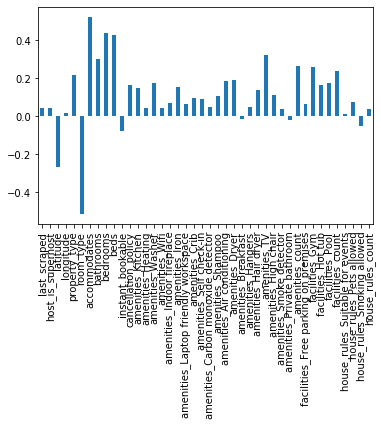

In [20]:
price_corr = full_df.corrwith(full_df["price"]).drop(["id", "price"])
price_corr.plot.bar()

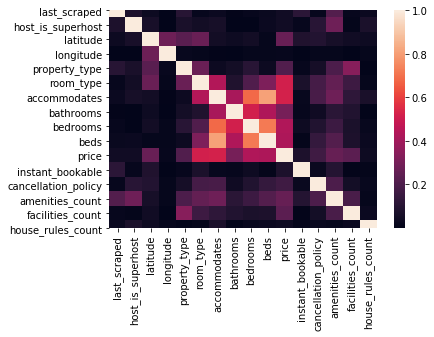

In [21]:
list_of_cols = ['last_scraped', 'host_is_superhost', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'price', 'instant_bookable', 'cancellation_policy',
       'amenities_count', 'facilities_count', 'house_rules_count']
corr = abs(full_df[list_of_cols].corr())

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [22]:
full_df.columns

Index(['id', 'last_scraped', 'host_is_superhost', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'amenities', 'price', 'instant_bookable', 'cancellation_policy',
       'amenities_Kitchen', 'amenities_Heating', 'amenities_Washer',
       'amenities_Wifi', 'amenities_Indoor fireplace', 'amenities_Iron',
       'amenities_Laptop friendly workspace', 'amenities_Crib',
       'amenities_Self check-in', 'amenities_Carbon monoxide detector',
       'amenities_Shampoo', 'amenities_Air conditioning', 'amenities_Dryer',
       'amenities_Breakfast', 'amenities_Hangers', 'amenities_Hair dryer',
       'amenities_TV', 'amenities_High chair', 'amenities_Smoke detector',
       'amenities_Private bathroom', 'amenities_count',
       'facilities_Free parking on premises', 'facilities_Gym',
       'facilities_Hot tub', 'facilities_Pool', 'facilities_count',
       'house_rules_Suitable for events', 'house_rules_Pets allowed',
    

In [23]:
print(price_corr)

last_scraped                           0.043693
host_is_superhost                      0.043983
latitude                              -0.269054
longitude                              0.019817
property_type                          0.215119
room_type                             -0.516345
accommodates                           0.523928
bathrooms                              0.302444
bedrooms                               0.437136
beds                                   0.428014
instant_bookable                      -0.075545
cancellation_policy                    0.165188
amenities_Kitchen                      0.147267
amenities_Heating                      0.041475
amenities_Washer                       0.177824
amenities_Wifi                         0.043772
amenities_Indoor fireplace             0.067794
amenities_Iron                         0.152737
amenities_Laptop friendly workspace    0.064971
amenities_Crib                         0.098852
amenities_Self check-in                0